In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import ipywidgets as widgets
from urllib.request import urlopen

## Loading the data

The data has been scraped and stored in a github repo. I will load it from there. The datafile contains train and test csvs and a json file that maps categories to index in other to maintain consistence across all works


In [2]:
train_url = 'https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/NewsCategorization/Data/train.csv'
test_url = 'https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/NewsCategorization/Data/test.csv'
mapping_url =  'https://raw.githubusercontent.com/chimaobi-okite/NLP-Projects-Competitions/main/NewsCategorization/Data/cat_mapping.json'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)
cat2index = json.loads(urlopen(mapping_url).read())

In [3]:
# see sample train data
train.head()

,Title,Excerpt,Category
0,"Uefa Opens Proceedings against Barcelona, Juve...",Uefa has opened disciplinary proceedings again...,sports
1,Amazon Blames Inflation as It Increases Cost o...,The increases are steeper than the 17 percent ...,business
2,Nigeria’s Parliament Passes Amended Electoral ...,Nigeria's Senate on Tuesday passed the harmoni...,politics
3,Nigeria: Lagos Governor Tests Positive for Cov...,"The Lagos State Governor, Mr. Babajide Sanwo-O...",health
4,South Africa Calls For Calm as Electoral Refor...,South Africa has raised concerns about the det...,politics


## Expository Data Analysis

In [4]:
print(f'The train data contains {train.shape[0]} datapoints')
print(f'The test data contains {test.shape[0]} datapoints')

The train data contains 4686 datapoints
The test data contains 828 datapoints


In [5]:
# create a copy of train data for analysis
train_eda = train.copy()

In [6]:
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4686 entries, 0 to 4685
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     4685 non-null   object
 1   Excerpt   4686 non-null   object
 2   Category  4686 non-null   object
dtypes: object(3)
memory usage: 110.0+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


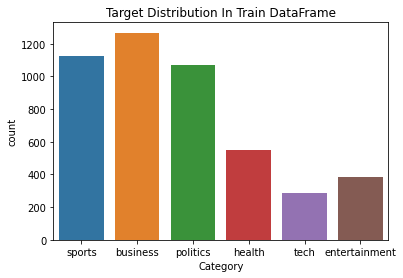

In [7]:
# see label distribution in train data
sns.countplot('Category', data = train_eda)
plt.title('Target Distribution In Train DataFrame')
plt.show()

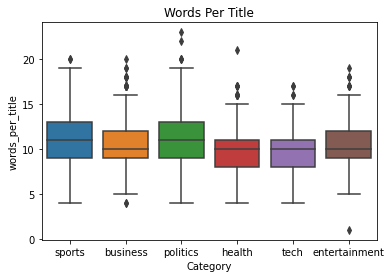

In [8]:
## see word count distribution in title column
train_eda['words_per_title'] = train_eda['Title'].map(lambda x : len(str(x).split()))
sns.boxplot(y = 'words_per_title', x = 'Category', data = train_eda)
plt.title('Words Per Title')
plt.show()

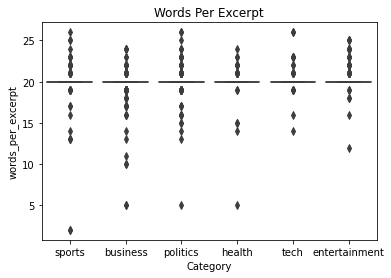

In [9]:
## see word count distribution in Excerpt column
train_eda['words_per_excerpt'] = train_eda['Excerpt'].map(lambda x : len(str(x).split()))
sns.boxplot(y = 'words_per_excerpt', x = 'Category', data = train_eda)
plt.title('Words Per Excerpt')
plt.show()

### Word Cloud

Explore if there is enough signal in the title and excerpt columns for accurately classifying news articles

In [10]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [11]:
# Title Word Cloud
@widgets.interact(tag = list(cat2index.keys()))
def display_word_cloud(tag = 'health'):
  plt.figure(figsize=(15,5))
  subset = train_eda[train_eda.Category == tag]
  text = subset.Title.values
  cloud = WordCloud(stopwords= STOPWORDS,background_color= 'black',
                    collocations= False, width= 500,
                    height= 300).generate(''.join([str(val) for val in text]))
  plt.axis('off')
  plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', options=('health', 'business', 'politics', 'entertainment', …

In [12]:
# Excerpt Word Cloud
@widgets.interact(tag = list(cat2index.keys()))
def display_word_cloud(tag = 'health'):
  plt.figure(figsize=(15,5))
  subset = train_eda[train_eda.Category == tag]
  text = subset.Excerpt.values
  cloud = WordCloud(stopwords= STOPWORDS,background_color= 'black',
                    collocations= False, width= 500,
                    height= 300).generate(''.join([str(val) for val in text]))
  plt.axis('off')
  plt.imshow(cloud)

interactive(children=(Dropdown(description='tag', options=('health', 'business', 'politics', 'entertainment', …

Insights from EDA

* We can see that the dataset is Imbalanced with most news around business and politics and just few for tech and sports. This might be due to the fact that most Nigerians are more interested in politics, business and health. We would try some dataset balnacing approaches.

* We can easily concatenate the title and excerpt column to a new column news without overshooting the number of words. So the models should be able to learn from this new column.

* From the word cloud we can see quite some distinctive words that characterize a news category. A good model shoud be able to learn from these features.

## Preprocessing

In [13]:
# create a copy of train / test data for preprocessing
df = train.copy()

### Feature engineering

In [14]:
df['News'] = df.Title + ". " + df.Excerpt

### Data Cleaning

* Convert to lowercase
* Remove none alpha numeric chars
* Remove stopwords
* Convert to words to root using stemmantization

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [16]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def clean_text(text, lower = True, stem = False, stopwords = STOPWORDS):
  if lower:
    text = text.lower()
  #remove stopwords
  if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)
  # Spacing and filters
  text = re.sub(
      r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
  )  # add spacing between objects to be filtered
  text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
  text = re.sub(" +", " ", text)  # remove multiple spaces
  text = text.strip()  # strip white space at the ends

  # Stemming
  if stem:
      text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

  return text

In [18]:
# text function
root_news = df['News'][0]
clean_news = clean_text(root_news)
stemmed_news = clean_text(root_news, stem = True)
print(root_news)
print(clean_news)
print(stemmed_news)

Uefa Opens Proceedings against Barcelona, Juventus and Real Madrid Over European Super League Plan. Uefa has opened disciplinary proceedings against Barcelona, Juventus and Real Madrid over their involvement in the proposed European Super League.
uefa opens proceedings barcelona juventus real madrid european super league plan uefa opened disciplinary proceedings barcelona juventus real madrid involvement proposed european super league
uefa open proceed barcelona juventu real madrid european super leagu plan uefa open disciplinari proceed barcelona juventu real madrid involv propos european super leagu


### Encoding

Encode categories to index

In [19]:
y = df['Category'].map(cat2index)

In [20]:
y = y.values

### Spliting

In [21]:
from sklearn.model_selection import train_test_split
index2cat = {v:k for k,v in cat2index.items()}
X = df['News'].values
X_train, X_val,  y_train, y_val = train_test_split(X, y, test_size = 0.15)
train_df = pd.DataFrame({'news': X_train, 'category': np.vectorize(index2cat.get)(y_train)})
val_df = pd.DataFrame({'news': X_val, 'category': np.vectorize(index2cat.get)(y_val)})
train_df.head()

,news,category
0,"Africa Surpasses 100,000 Confirmed Covid-19 De...",health
1,Rwandan President Kagame Wants To Build Africa...,business
2,Court Clears Way for CBN’s eNaira Launch. The ...,business
3,"Trump Organization, CFO Charged in ‘Sweeping’ ...",business
4,Nigeria’s Central Bank Investigates Cryptocurr...,business


## Modelling

In [22]:
from sklearn.metrics import precision_recall_fscore_support

In [23]:
import random
def set_seed(seed = 42):
  '''Set seed for reproduciability'''
  np.random.seed(42)
  random.seed(42)

In [24]:
def preprocess(df, lower, stem):
  '''Process Dataframe'''
  df['news'] = df['Title'].map(str) + '. ' + df['Excerpt'].map(str)
  df.news = df.news.apply(clean_text, lower=lower, stem=stem)
  return df

In [25]:
def get_data_splits(X, y, test_size = 0.2):
  """Generate balanced data splits."""
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=test_size, stratify=y)
  return X_train,X_val, y_train, y_val

### Baseline

See how well a random guess does

In [26]:
from sklearn.dummy import DummyClassifier

In [27]:
#setup
set_seed()
df = train.copy()
df = preprocess(df, lower = True, stem = False)
X_train,X_val, y_train, y_val = get_data_splits(df.news, df.Category.map(cat2index))

In [28]:
# fit to dummy classifier
du_clf = DummyClassifier(strategy= 'stratified')
du_clf.fit(X_train, y_train)

# evaluate prediction
y_pred = du_clf.predict(X_val)
metrics = precision_recall_fscore_support(y_val, y_pred, average="weighted")
performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.19188062707659517,
  "recall": 0.18976545842217485,
  "f1": 0.19030668884143737
}


### Machine Leaning

In [29]:
#setup
set_seed()
df = train.copy()
df = preprocess(df, lower = True, stem = False)
X_train,X_val, y_train, y_val = get_data_splits(df.news, df.Category.map(cat2index))

#### Vectorizer

In [30]:
## create copy of val-raw data to use later
X_val_raw = X_val.copy()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
vectorizer = TfidfVectorizer(analyzer= 'char', ngram_range= (2,7))
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
print(X_train.shape)
print(X_val.shape)

(3748, 491068)
(938, 491068)


### Data Imbalnace

from eda we saw that the dataset is not balanced with classes like tech having little data points. We would explore if oversampling the less frequent class will help improve performance



In [33]:
from imblearn.over_sampling import RandomOverSampler

In [34]:
over_sampler = RandomOverSampler(sampling_strategy= 'all')
X_over, y_over = over_sampler.fit_resample(X_train, y_train)

### Model Fitting

In [35]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [36]:
%%time
log_model = LogisticRegression()
# fit on unsampled train
log_model.fit(X_train, y_train)

# inspect performance
y_pred = log_model.predict(X_val)
metrics = precision_recall_fscore_support(y_val, y_pred, average="weighted")
performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8256478661955915,
  "recall": 0.8347547974413646,
  "f1": 0.8206363794559867
}
CPU times: user 1min 23s, sys: 30.8 s, total: 1min 53s
Wall time: 1min 14s


In [37]:
# fit and make prediction with sampled data
# fit on unsampled train
log_model.fit(X_over, y_over)

# inspect performance
y_pred = log_model.predict(X_val)
metrics = precision_recall_fscore_support(y_val, y_pred, average="weighted")
performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8706576772772313,
  "recall": 0.8699360341151386,
  "f1": 0.8700584360478381
}


Wow, a logistics regression model had such great performance. How well will Lightgbm perform? Lets check

In [38]:
from lightgbm import LGBMClassifier

In [39]:
%%time
light_model = LGBMClassifier()
# fit on unsampled train
light_model.fit(X_train, y_train)

# inspect performance
y_pred = light_model.predict(X_val)
metrics = precision_recall_fscore_support(y_val, y_pred, average="weighted")
performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8141883484113184,
  "recall": 0.8208955223880597,
  "f1": 0.8138960647257657
}
CPU times: user 8min 34s, sys: 722 ms, total: 8min 35s
Wall time: 4min 26s


In [40]:
# fit and make prediction with sampled data
# fit on unsampled train
light_model.fit(X_over, y_over)

# inspect performance
y_pred = light_model.predict(X_val)
metrics = precision_recall_fscore_support(y_val, y_pred, average="weighted")
performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8203193815122596,
  "recall": 0.8251599147121536,
  "f1": 0.8214550281518949
}


Our Logistics Regression model with data augmentation gave a better performance at a much faster rate. Though we can tune the LightGBm to get better results but considering the wall-time above. It is best to stick with LR. Will use this as a baseline going forward.

## Error Analysis and Evaluation

* Check the per class f1-scores and verify what classes are mostly misclassified and why
* Check how different threshold probabilities affect performance

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [42]:
def plot_confusion_matrix(y_preds, y_true, labels):
  '''Plots the confusion matrix given set of labels and predictions'''
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  plt.show()

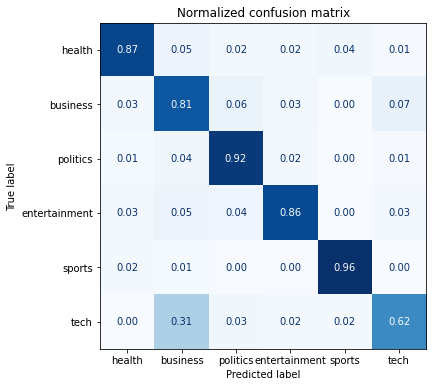

In [43]:
# see confusion matrix
y_preds = log_model.predict(X_val)
y_true = y_val
labels = cat2index.keys()
plot_confusion_matrix(y_preds, y_true, labels)

In [44]:
# see misclassified news
pred_proba = np.max(log_model.predict_proba(X_val), axis=1)
preds_df = pd.DataFrame({'news': X_val_raw, 'true_label': y_val, 
                         'pred_label': y_preds, 'pred_proba':pred_proba})
preds_df['true_label'] = preds_df['true_label'].map(index2cat)
preds_df['pred_label'] = preds_df['pred_label'].map(index2cat)
preds_df = preds_df.sort_values(by= 'pred_proba')
# preds_df[preds_df['true_label'] == 'tech']
preds_df

,news,true_label,pred_label,pred_proba
311,lagos shuts 21 illegal substandard pharmacies ...,health,health,0.211324
1365,nigeria meets cameroon repatriation 4 982 born...,politics,politics,0.216323
3921,china sanction us officials nasty behaviour ta...,politics,business,0.221432
1246,china xiaomi files legal complaint us defence ...,tech,tech,0.228100
3652,african union urges ceasefire ethiopia tigray ...,politics,politics,0.230695
...,...,...,...,...
630,us authorizes pfizer covid 19 vaccine emergenc...,health,health,0.991686
999,peter obi resigns pdp withdraws party presiden...,politics,politics,0.992995
3004,nigeria end hunger insecurity elected presiden...,politics,politics,0.993905
1868,nigeria riding national mood former anambra go...,politics,politics,0.995173


In [45]:
def print_classification_report(y_true, y_pred):
  y_true = np.vectorize(index2cat.get)(y_true) 
  y_pred = np.vectorize(index2cat.get)(y_pred)
  print(classification_report(y_true,y_pred))

In [46]:
from ipywidgets.widgets.widget_float import FloatSlider
@widgets.interact(threshold = FloatSlider(min=0.1, max=1.0, step=0.1, value=0.5))
def get_thresholds(threshold = 0.5):
  '''Compare results across several threshold probability'''
  y_preds = log_model.predict(X_val)
  y_true = y_val
  y_proba = np.max(log_model.predict_proba(X_val), axis=1)
  raw = X_val_raw.to_numpy()
  indices = y_proba > threshold

  pred = y_preds[indices]
  true = y_true[indices]
  print_classification_report(true, pred)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, min=0.1), Output()), _dom_class…

*Insights From Error Analysis and Evaluation*


1. We can also see most of the misclassifications comes from the model classifying tech examples as business. The reason being that:
* In today's world,the top business leaders are tech companies so it is difficult to decouple one from the other. 
* There are just few tech examples in the dataset, with more, the model should be able to learn more useful features to correctly differentiate between the two classes.

2.  We also saw that at thresholds above 0.7 the model correctly classifies most classes expect tech. this might be an indication to remove the tech class from the dataset as the model has difficulty recognising it. 

### Interpretability

use Lime for text interpretation

In [47]:
!pip install -qq lime

     |████████████████████████████████| 275 kB 7.6 MB/s 


In [48]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [49]:
pipe = make_pipeline(vectorizer, log_model)

In [50]:
text = X_val_raw.values[10]
print(text)
explainer = LimeTextExplainer(class_names=cat2index.keys())
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

questions mount mtn nigeria alleged payment n618 7bn taxes firs mtn nigeria communications plc claim paid sum n618 7 billion direct indirect taxes


## Optimization and Experiment Tracking

In [51]:
!pip install -qq mlflow optuna numpyencoder 

     |████████████████████████████████| 17.0 MB 165 kB/s 
     |████████████████████████████████| 348 kB 52.2 MB/s 
     |████████████████████████████████| 181 kB 68.3 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 146 kB 56.4 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 209 kB 45.7 MB/s 
     |████████████████████████████████| 78 kB 8.8 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 59 kB 8.1 MB/s 
     |████████████████████████████████| 81 kB 11.6 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 112 kB 49.0 MB/s 
     |████████████████████████████████| 147 kB 57.7 MB/s 


In [52]:
from argparse import Namespace
import mlflow
from pathlib import Path
import joblib
import tempfile
import optuna

In [53]:
# Specify arguments
args = Namespace(
    lower=True,
    stem=False,
    random_state = 42,
    analyzer='char',
    ngram_min_range = 2,
    ngram_max_range=7,
    C = 1
)

In [54]:
vars(args)


{'lower': True,
 'stem': False,
 'random_state': 42,
 'analyzer': 'char',
 'ngram_min_range': 2,
 'ngram_max_range': 7,
 'C': 1}

In [55]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file:///" + str(MODEL_REGISTRY.absolute()))

In [56]:
def train(args, df, trial = None):
  set_seed()
  df = preprocess(df, lower = True, stem = args.stem)
  X_train,X_val, y_train, y_val = get_data_splits(df.news, df.Category.map(cat2index))

  vectorizer = TfidfVectorizer(analyzer= args.analyzer, ngram_range= (args.ngram_min_range,args.ngram_max_range))
  X_train = vectorizer.fit_transform(X_train)
  X_val = vectorizer.transform(X_val)

  over_sampler = RandomOverSampler(sampling_strategy= 'all')
  X_over, y_over = over_sampler.fit_resample(X_train, y_train)

  model = LogisticRegression(C = args.C, random_state = args.random_state, max_iter= 1000)
  model.fit(X_over, y_over)

  if trial:
      if trial.should_prune():
          raise optuna.TrialPruned()

  # inspect performance
  y_pred = model.predict(X_val)
  metrics = precision_recall_fscore_support(y_val, y_pred, average="weighted")
  performance = {'precision': metrics[0], 'recall': metrics[1], 'f1': metrics[2]}
  print (json.dumps(performance, indent=2))

  return {
        "args": args,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

In [57]:
text = df['news'][3]
index2cat = {v:k for k,v in cat2index.items()}
texts = [text]
x = vectorizer.transform(texts)
y_prob = np.max(log_model.predict_proba(x), axis = 1)
y_pred = log_model.predict(x)
category = np.vectorize(index2cat.get)(y_pred)
predictions =  {
        'input_text': text,
        'predicted_category': category[0],
        'predicted_prob' : y_prob[0]
    }
predictions

{'input_text': 'nigeria lagos governor tests positive covid 19 kaduna governor self isolates lagos state governor mr babajide sanwo olu tested positive covid 19 commissioner health professor akin abayomi said',
 'predicted_category': 'health',
 'predicted_prob': 0.8382712271665901}

In [58]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)

In [59]:
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [60]:
mlflow.set_experiment('baseline')
with mlflow.start_run():
  artifacts = train(args = args, df = df)
  mlflow.log_params(vars(args))
  # Log key metrics
  mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
  mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
  mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})
  # Log artifacts
  with tempfile.TemporaryDirectory() as dp:
      joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
      joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
      save_dict(artifacts["performance"], Path(dp, "performance.json"))
      mlflow.log_artifacts(dp)

2022/09/02 10:25:55 INFO mlflow.tracking.fluent: Experiment with name 'baseline' does not exist. Creating a new experiment.


{
  "precision": 0.8706576772772313,
  "recall": 0.8699360341151386,
  "f1": 0.8700584360478381
}


In [61]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baseline").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
print (all_runs)

                             run_id experiment_id    status  \
0  5b5139f35c1e477695a587f9602414b4             0  FINISHED   

                                        artifact_uri  \
0  file://content/experiments/0/5b5139f35c1e47769...   

                        start_time                         end_time  \
0 2022-09-02 10:25:56.274000+00:00 2022-09-02 10:27:41.368000+00:00   

   metrics.f1  metrics.precision  metrics.recall params.analyzer  \
0    0.870058           0.870658        0.869936            char   

  params.ngram_max_range params.lower params.ngram_min_range params.C  \
0                      7         True                      2        1   

  params.stem params.random_state  \
0       False                  42   

                             tags.mlflow.source.name tags.mlflow.user  \
0  /usr/local/lib/python3.7/dist-packages/ipykern...             root   

  tags.mlflow.source.type  
0                   LOCAL  


In [62]:
# Best run
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
dp = Path('artifacts')
Path(dp).mkdir(exist_ok=True)
client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
model = joblib.load(Path(dp, "model.pkl"))
performance = load_dict(filepath=Path(dp, "performance.json"))


In [63]:
def objective(args, trial):
    """Objective function for optimization trials."""
    # Parameters to tune
    # args.ngram_max_range = trial.suggest_int('ngram_max_range', 3, 10)
    args.C = trial.suggest_categorical('C', [0.001, 0.01, 0.1, 1, 10, 100, 1000])
    # args.stem = trial.suggest_categorical('stem', [True, False])

    # Train & evaluate
    artifacts = train(args=args, df=df, trial=trial)

    # Set additional attributes
    performance = artifacts["performance"]
    print(json.dumps(performance, indent=2))
    trial.set_user_attr("precision", performance["precision"])
    trial.set_user_attr("recall", performance["recall"])
    trial.set_user_attr("f1", performance["f1"])

    return performance["f1"]

In [64]:
from numpyencoder import NumpyEncoder
from optuna.integration.mlflow import MLflowCallback

In [65]:
NUM_TRIALS = 7 # small sample for now

In [66]:
# Optimize
%%time
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimization", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(args, trial),
            n_trials=NUM_TRIALS,
            callbacks=[mlflow_callback])

[I 2022-09-02 10:29:26,878] A new study created in memory with name: optimization
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  after removing the cwd from sys.path.
[I 2022-09-02 10:31:06,663] Trial 0 finished with value: 0.8700584360478381 and parameters: {'C': 1}. Best is trial 0 with value: 0.8700584360478381.
2022/09/02 10:31:06 INFO mlflow.tracking.fluent: Experiment with name 'optimization' does not exist. Creating a new experiment.


{
  "precision": 0.8706576772772313,
  "recall": 0.8699360341151386,
  "f1": 0.8700584360478381
}
{
  "precision": 0.8706576772772313,
  "recall": 0.8699360341151386,
  "f1": 0.8700584360478381
}


[I 2022-09-02 10:35:40,276] Trial 1 finished with value: 0.8720765498858766 and parameters: {'C': 100}. Best is trial 1 with value: 0.8720765498858766.


{
  "precision": 0.8717157453314522,
  "recall": 0.8731343283582089,
  "f1": 0.8720765498858766
}
{
  "precision": 0.8717157453314522,
  "recall": 0.8731343283582089,
  "f1": 0.8720765498858766
}


[I 2022-09-02 10:37:14,270] Trial 2 finished with value: 0.8700584360478381 and parameters: {'C': 1}. Best is trial 1 with value: 0.8720765498858766.


{
  "precision": 0.8706576772772313,
  "recall": 0.8699360341151386,
  "f1": 0.8700584360478381
}
{
  "precision": 0.8706576772772313,
  "recall": 0.8699360341151386,
  "f1": 0.8700584360478381
}


[I 2022-09-02 10:41:51,771] Trial 3 finished with value: 0.8720765498858766 and parameters: {'C': 100}. Best is trial 1 with value: 0.8720765498858766.


{
  "precision": 0.8717157453314522,
  "recall": 0.8731343283582089,
  "f1": 0.8720765498858766
}
{
  "precision": 0.8717157453314522,
  "recall": 0.8731343283582089,
  "f1": 0.8720765498858766
}


[I 2022-09-02 10:44:37,327] Trial 4 finished with value: 0.8720614924800316 and parameters: {'C': 10}. Best is trial 1 with value: 0.8720765498858766.


{
  "precision": 0.8715512361015963,
  "recall": 0.8731343283582089,
  "f1": 0.8720614924800316
}
{
  "precision": 0.8715512361015963,
  "recall": 0.8731343283582089,
  "f1": 0.8720614924800316
}


[I 2022-09-02 10:44:53,024] Trial 5 finished with value: 0.8290323201596196 and parameters: {'C': 0.001}. Best is trial 1 with value: 0.8720765498858766.


{
  "precision": 0.8419539786437225,
  "recall": 0.8283582089552238,
  "f1": 0.8290323201596196
}
{
  "precision": 0.8419539786437225,
  "recall": 0.8283582089552238,
  "f1": 0.8290323201596196
}


[I 2022-09-02 10:45:09,042] Trial 6 finished with value: 0.8290323201596196 and parameters: {'C': 0.001}. Best is trial 1 with value: 0.8720765498858766.


{
  "precision": 0.8419539786437225,
  "recall": 0.8283582089552238,
  "f1": 0.8290323201596196
}
{
  "precision": 0.8419539786437225,
  "recall": 0.8283582089552238,
  "f1": 0.8290323201596196
}
CPU times: user 17min 53s, sys: 6min 11s, total: 24min 4s
Wall time: 15min 42s


The above just shows the process of experiment tracking and parameter optimization with mlflow. I did not include the whole param space and only ran for 7 trails due to device constraints. The goal of the cell above is to show how optuna canbe integrated with mlflow.

In [67]:
# Run MLFlow server and localtunnel
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

npx: installed 22 in 4.978s
your url is: https://large-places-share-34-125-113-25.loca.lt
^C


## Evaluating Performance of model on Test set

In [71]:
test_df = preprocess(test, lower = True, stem = False)
X_test,y_test = test_df.news, test_df.Category.map(cat2index)
X_test = vectorizer.transform(X_test)

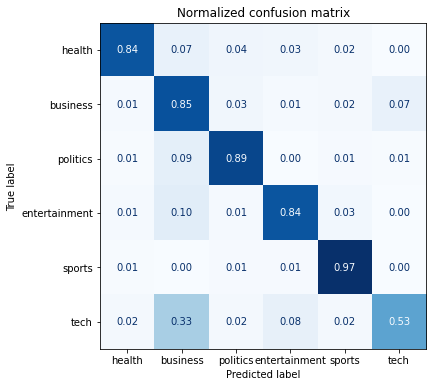

In [72]:
test_preds = model.predict(X_test)
y_true = y_test
labels = cat2index.keys()
plot_confusion_matrix(test_preds, y_true, labels)

In [73]:
print_classification_report(y_true, test_preds)

               precision    recall  f1-score   support

     business       0.80      0.85      0.83       224
entertainment       0.82      0.84      0.83        67
       health       0.92      0.84      0.88        97
     politics       0.92      0.89      0.90       190
       sports       0.95      0.97      0.96       199
         tech       0.61      0.53      0.57        51

     accuracy                           0.87       828
    macro avg       0.84      0.82      0.83       828
 weighted avg       0.87      0.87      0.87       828

